Mount the drive to use github repository episodic-memory and download the dataset on /content/ folder in Google Colab, in order to start the session

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unmount the drive, run just when you finish or you have issues related to syncronization or Google Colab runtime timeout

In [10]:
from google.colab import drive
drive.flush_and_unmount()
print('Drive disconnesso con successo.')

Drive disconnesso con successo.


Change directory for each cell

In [ ]:
%cd "/content/drive/MyDrive/EgoVisionProject/Code/episodic_memory/NLQ/VSLNet"

/content/drive/MyDrive/EgoVisionProject/Code/episodic_memory/NLQ/VSLNet


Initialize enviroment variables in vars.sh file

*   NAME: change model used (vsl_net/vsl_base) and pre extracted features (omnivore_fp16/ego_vlp_fp16) and run number (run1,run2,...)
*   FEATURE_DIR: change the path based on different extracted features ((dollar symbol)LOCAL_DATA_ROOT/ego4d_data/v1/egovlp_fp16 or $LOCAL_DATA_ROOT/ego4d_data/v1/omnivore_video_swinl_fp16



In [ ]:
with open("vars.sh", "w") as out_f:
  out_f.write("""
export NAME=LLM_Data_Augumentation_pre-training_vsl_net_egovlp_fp16_run4
export TASK_NAME=nlq_official_v1_$NAME
export FEATURE_SOURCE_ZIP_PATH=/content/drive/MyDrive/EgoVisionProject/Data
export DRIVE_ZIP_FILENAME=ego4d_data.zip
export MODEL_BASE_DIR=/content/drive/MyDrive/EgoVisionProject/Experiments
export LOCAL_DATA_ROOT=/content/colab_local_storage
export BASE_DIR=$LOCAL_DATA_ROOT/dataset/$TASK_NAME
export FEATURE_BASE_DIR=$LOCAL_DATA_ROOT/features/$TASK_NAME/official
export FEATURE_DIR=$LOCAL_DATA_ROOT/ego4d_data/v1/egovlp_fp16
export LOCAL_ANNOTATIONS_DIR=$LOCAL_DATA_ROOT/ego4d_data/v1/annotations
export NARRATION_LOCAL_PATH=$LOCAL_ANNOTATIONS_DIR/narration.json
export LOCAL_TRAIN_SPLIT=$LOCAL_ANNOTATIONS_DIR/nlq_train.json
export LOCAL_VAL_SPLIT=$LOCAL_ANNOTATIONS_DIR/nlq_val.json
export LOCAL_TEST_SPLIT=$LOCAL_ANNOTATIONS_DIR/nlq_test_unannotated.json
export LOCAL_MODEL_DIR=$LOCAL_DATA_ROOT/experiments

"""
  )

Upload the dataset from the zip file on google colab

In [ ]:
%%bash
source vars.sh

# Create local directory

mkdir -p "$LOCAL_DATA_ROOT"


# Absolute path of the zip file on the drive
DRIVE_ZIP_FILE_PATH="$FEATURE_SOURCE_ZIP_PATH/$DRIVE_ZIP_FILENAME"
# Temporany path to copy the zip file
LOCAL_TEMP_ZIP_FILE="/content/$DRIVE_ZIP_FILENAME"


if [ -f "$DRIVE_ZIP_FILE_PATH" ]; then # Check if the file exist
    cp "$DRIVE_ZIP_FILE_PATH" "$LOCAL_TEMP_ZIP_FILE"

    #unzip the file
    unzip -o -q "$LOCAL_TEMP_ZIP_FILE" -d "$LOCAL_DATA_ROOT"

    #remove temporany file
    rm "$LOCAL_TEMP_ZIP_FILE"

else
    echo "ERROR: file doesn't found"
    exit 1 # Script stopped
fi


Install libreries and dependencies


In [ ]:
%%bash
%%capture

source vars.sh
pip install pandas matplotlib seaborn nltk submitit torch torchaudio torchvision tqdm transformers tensorboard Pillow terminaltables accelerate bitsandbytes sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 137.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

bash: line 1: fg: no job control


Data exploration


In [ ]:
# --- Cella 1: Import delle librerie ---
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Impostazioni grafiche per i plot
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# --- Cella 2: Funzione per parsare i file JSON ---
def parse_nlq_to_dataframe(file_path):
    """
    Legge un file JSON NLQ e lo converte in un DataFrame pandas.
    """
    print(f"Processing {file_path}...")
    with open(file_path, 'r') as f:
        data = json.load(f)

    records = []
    for video_info in data["videos"]:
        video_uid = video_info["video_uid"]
        for clip_info in video_info["clips"]:
            clip_uid = clip_info["clip_uid"]
            clip_duration = clip_info["video_end_sec"] - clip_info["video_start_sec"]
            for ann_info in clip_info["annotations"]:
                for query_info in ann_info["language_queries"]:
                    answer_start_sec = query_info.get("video_start_sec")
                    answer_end_sec = query_info.get("video_end_sec")

                    # Calcola la durata della risposta solo se i dati sono validi
                    answer_duration = None
                    if answer_start_sec is not None and answer_end_sec is not None:
                        answer_duration = answer_end_sec - answer_start_sec

                    records.append({
                        "video_uid": video_uid,
                        "clip_uid": clip_uid,
                        "query": query_info.get("query"),
                        "template": query_info.get("template"),
                        "clip_duration_sec": clip_duration,
                        "answer_start_sec": answer_start_sec,
                        "answer_end_sec": answer_end_sec,
                        "answer_duration_sec": answer_duration,
                    })
    return pd.DataFrame(records)

# --- Cella 3: Caricamento e unione dei dati ---
# Assicurati che i percorsi dei file siano corretti!
train_df = parse_nlq_to_dataframe('percorso/a/nlq_train.json')
val_df = parse_nlq_to_dataframe('percorso/a/nlq_val.json')

# Uniamo train e val per un'analisi complessiva
full_df = pd.concat([train_df, val_df], ignore_index=True)

# Rimuovi eventuali righe con dati mancanti per le analisi numeriche
full_df.dropna(subset=['query', 'template', 'answer_duration_sec'], inplace=True)

print(f"\nTotal queries loaded for analysis: {len(full_df)}")
full_df.head()

Template queries distribution

<ipython-input-8-c42fbfc308d5>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


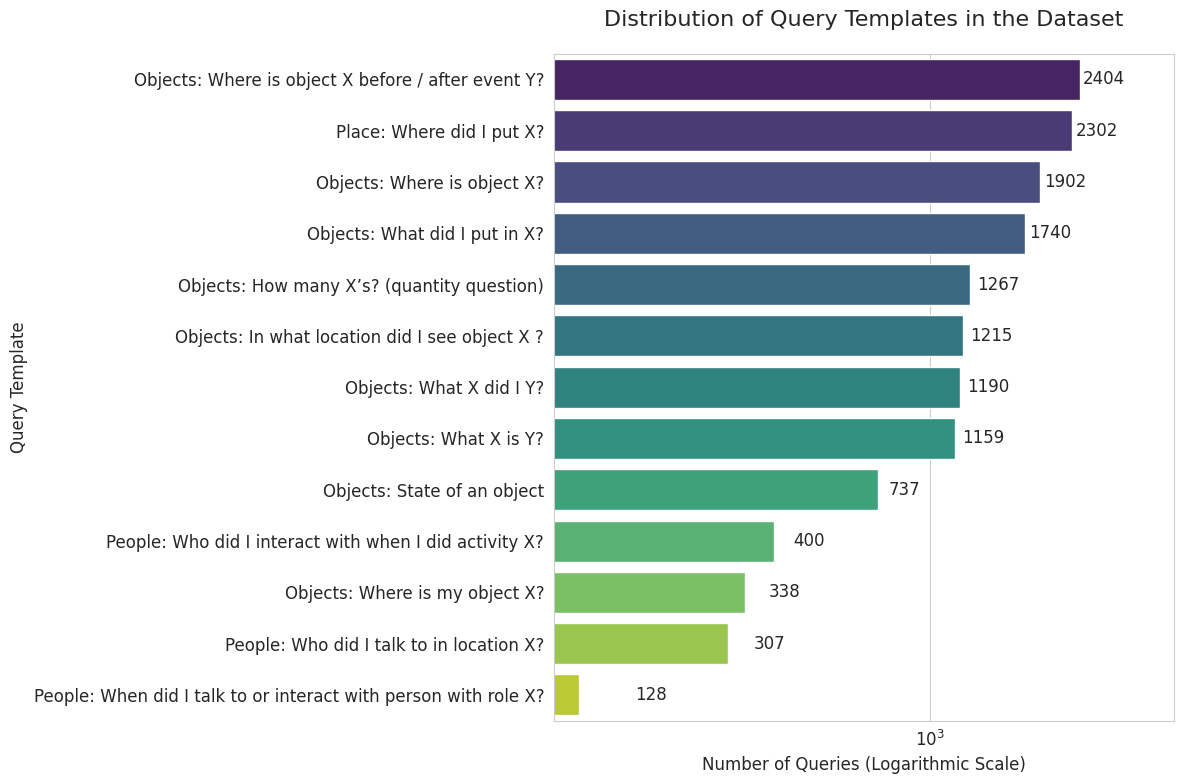

In [ ]:
# Cella per il Grafico 1: Distribuzione dei Template (con conteggio numerico)
import matplotlib.pyplot as plt
import seaborn as sns

# Impostazioni grafiche
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Creazione del grafico, salvando l'oggetto Axes in 'ax'
ax = sns.countplot(
    y=full_df['template'],
    order=full_df['template'].value_counts().index,
    palette='viridis'
)

# --- CODICE AGGIUNTO PER MOSTRARE I NUMERI ---
# Questo ciclo itera su ogni barra (patch) nel grafico
for p in ax.patches:
    # Prende la larghezza della barra (che è il nostro conteggio)
    width = p.get_width()
    # Scrive il testo accanto alla barra
    ax.text(
        width + 50,  # Posizione x (un po' a destra della barra per non sovrapporsi)
        p.get_y() + p.get_height() / 2, # Posizione y (al centro verticale della barra)
        f'{int(width)}', # Il testo da visualizzare (il numero intero)
        va='center'  # Allineamento verticale al centro
    )
# --- FINE DEL CODICE AGGIUNTO ---

plt.title('Distribution of Query Templates in the Dataset', fontsize=16, pad=20)
plt.xlabel('Number of Queries (Logarithmic Scale)', fontsize=12)
plt.ylabel('Query Template', fontsize=12)
plt.xscale('log') # Manteniamo la scala logaritmica per la visualizzazione

# Aumenta leggermente il limite dell'asse x per fare spazio ai numeri
current_xlim = plt.xlim()
plt.xlim(current_xlim[0], current_xlim[1] * 1.5)

plt.tight_layout()
plt.show()

Clip lengths & Prediction lengths

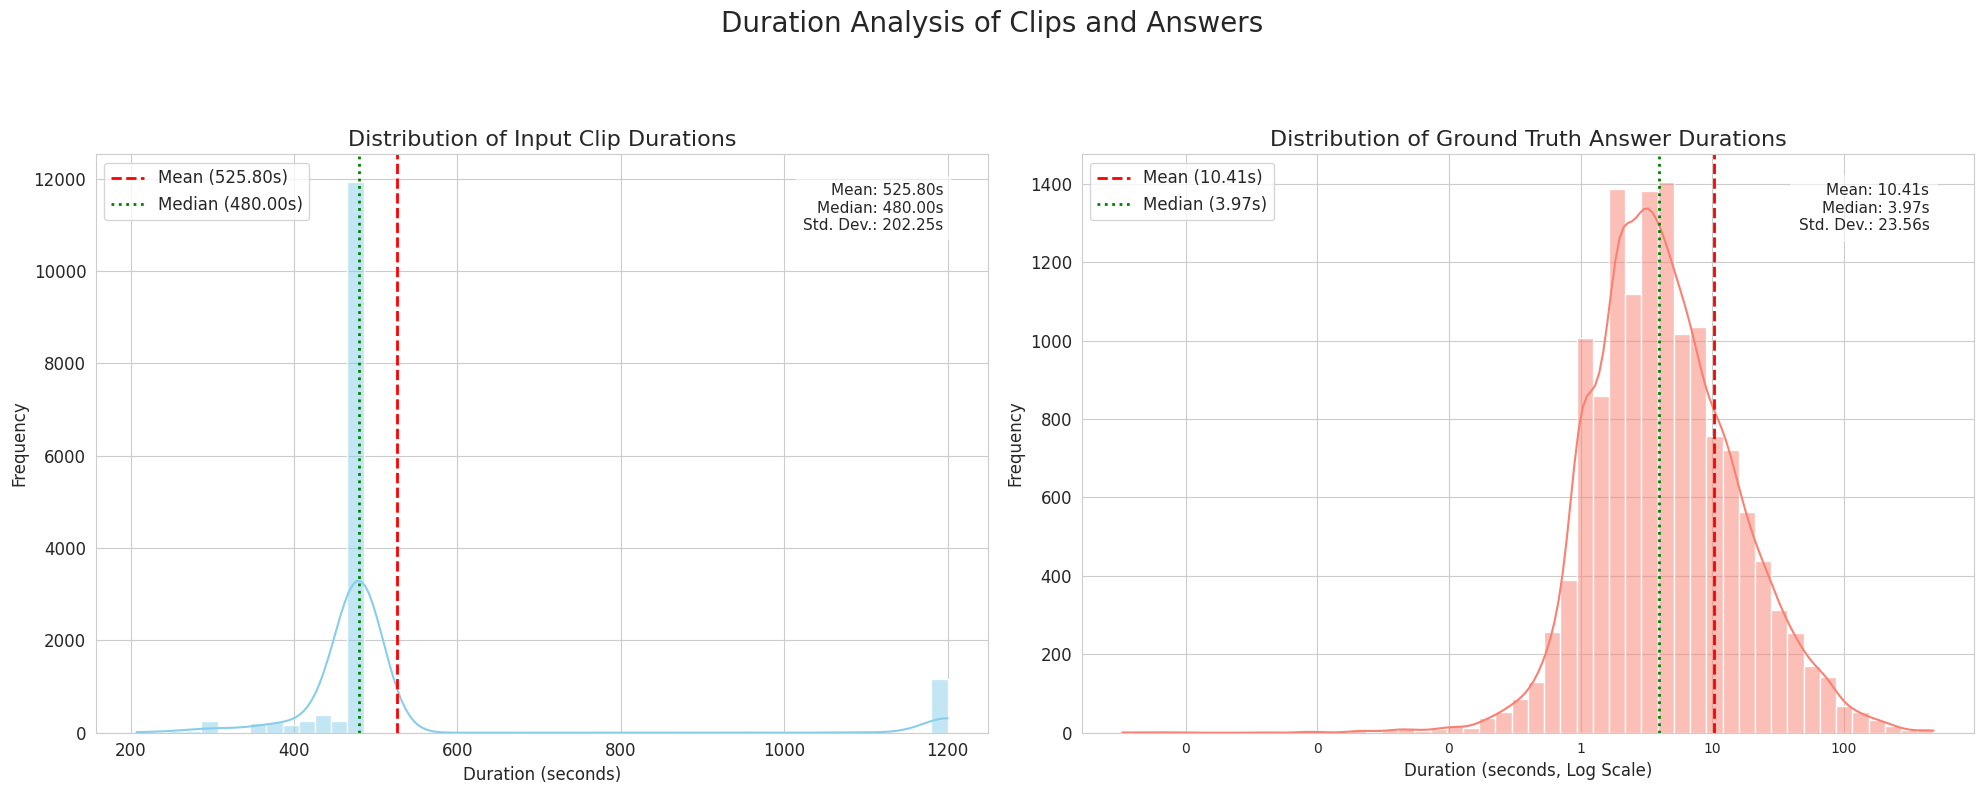

In [ ]:
# Cell for the improved Duration Analysis Plot (English Version)
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

# Assuming the 'full_df' DataFrame has already been loaded and prepared
# Filter for valid durations to ensure proper analysis
answers_df = full_df[full_df['answer_duration_sec'] > 0].copy()

# --- 1. Calculate descriptive statistics ---
# For clip durations
clip_mean = full_df['clip_duration_sec'].mean()
clip_median = full_df['clip_duration_sec'].median()
clip_std = full_df['clip_duration_sec'].std()

# For answer durations
answer_mean = answers_df['answer_duration_sec'].mean()
answer_median = answers_df['answer_duration_sec'].median()
answer_std = answers_df['answer_duration_sec'].std()

# Prepare the stats text to display on the plots
clip_stats_text = (
    f"Mean: {clip_mean:.2f}s\n"
    f"Median: {clip_median:.2f}s\n"
    f"Std. Dev.: {clip_std:.2f}s"
)
answer_stats_text = (
    f"Mean: {answer_mean:.2f}s\n"
    f"Median: {answer_median:.2f}s\n"
    f"Std. Dev.: {answer_std:.2f}s"
)


# --- 2. Create the Plot ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Duration Analysis of Clips and Answers', fontsize=20, y=1.02)


# --- Left Plot: Input Clip Durations ---
sns.histplot(full_df['clip_duration_sec'], bins=50, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Input Clip Durations', fontsize=16)
axes[0].set_xlabel('Duration (seconds)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Add vertical lines for mean and median
axes[0].axvline(clip_mean, color='red', linestyle='--', linewidth=2, label=f'Mean ({clip_mean:.2f}s)')
axes[0].axvline(clip_median, color='green', linestyle=':', linewidth=2, label=f'Median ({clip_median:.2f}s)')
axes[0].legend()

# Add the stats box
axes[0].text(0.95, 0.95, clip_stats_text, transform=axes[0].transAxes, fontsize=11,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.6))


# --- Right Plot: Ground Truth Answer Durations ---
sns.histplot(answers_df['answer_duration_sec'], bins=50, ax=axes[1], color='salmon', kde=True, log_scale=True)
axes[1].set_title('Distribution of Ground Truth Answer Durations', fontsize=16)
axes[1].set_xlabel('Duration (seconds, Log Scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Format the x-axis ticks to show plain numbers instead of powers of 10
axes[1].xaxis.set_major_formatter(mticker.ScalarFormatter())
axes[1].xaxis.get_major_formatter().set_scientific(False)
axes[1].tick_params(axis='x', which='major', labelsize=10)


# Add vertical lines for mean and median
axes[1].axvline(answer_mean, color='red', linestyle='--', linewidth=2, label=f'Mean ({answer_mean:.2f}s)')
axes[1].axvline(answer_median, color='green', linestyle=':', linewidth=2, label=f'Median ({answer_median:.2f}s)')
axes[1].legend()

# Add the stats box
axes[1].text(0.95, 0.95, answer_stats_text, transform=axes[1].transAxes, fontsize=11,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.6))


# --- Finalization ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Anlysis prediction position respect than video clip

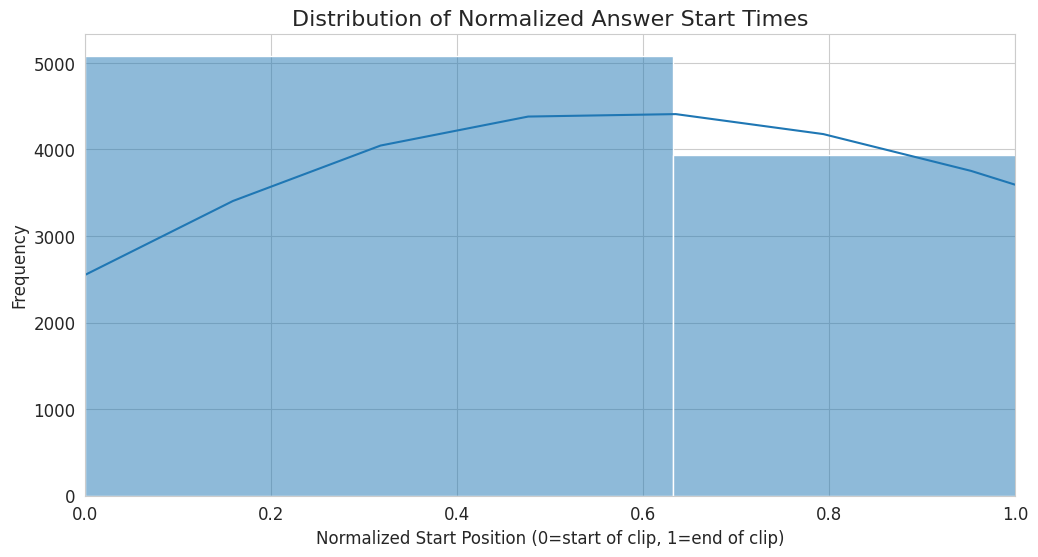

In [ ]:
# --- Cella 6: Analisi della posizione normalizzata ---

# Calcola la posizione di inizio normalizzata (0 = inizio clip, 1 = fine clip)
# Ignoriamo le clip con durata nulla per evitare divisioni per zero
df_filtered = full_df[full_df['clip_duration_sec'] > 0].copy()
df_filtered['normalized_start_time'] = df_filtered['answer_start_sec'] / df_filtered['clip_duration_sec']

plt.figure(figsize=(12, 6))
sns.histplot(df_filtered['normalized_start_time'], bins=50, kde=True)
plt.title('Distribution of Normalized Answer Start Times', fontsize=16)
plt.xlabel('Normalized Start Position (0=start of clip, 1=end of clip)')
plt.ylabel('Frequency')
plt.xlim(0, 1)
plt.show()

Words and scenario analysis

--- Generating a Grid of Ordered Bar Charts for Top 5 Scenarios ---

--- Generating Plots ---


<ipython-input-24-b1525e8197cf>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-24-b1525e8197cf>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-24-b1525e8197cf>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-24-b1525e8197cf>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-24-b1525e8197cf>:80: FutureWarning: 

Passing `pa

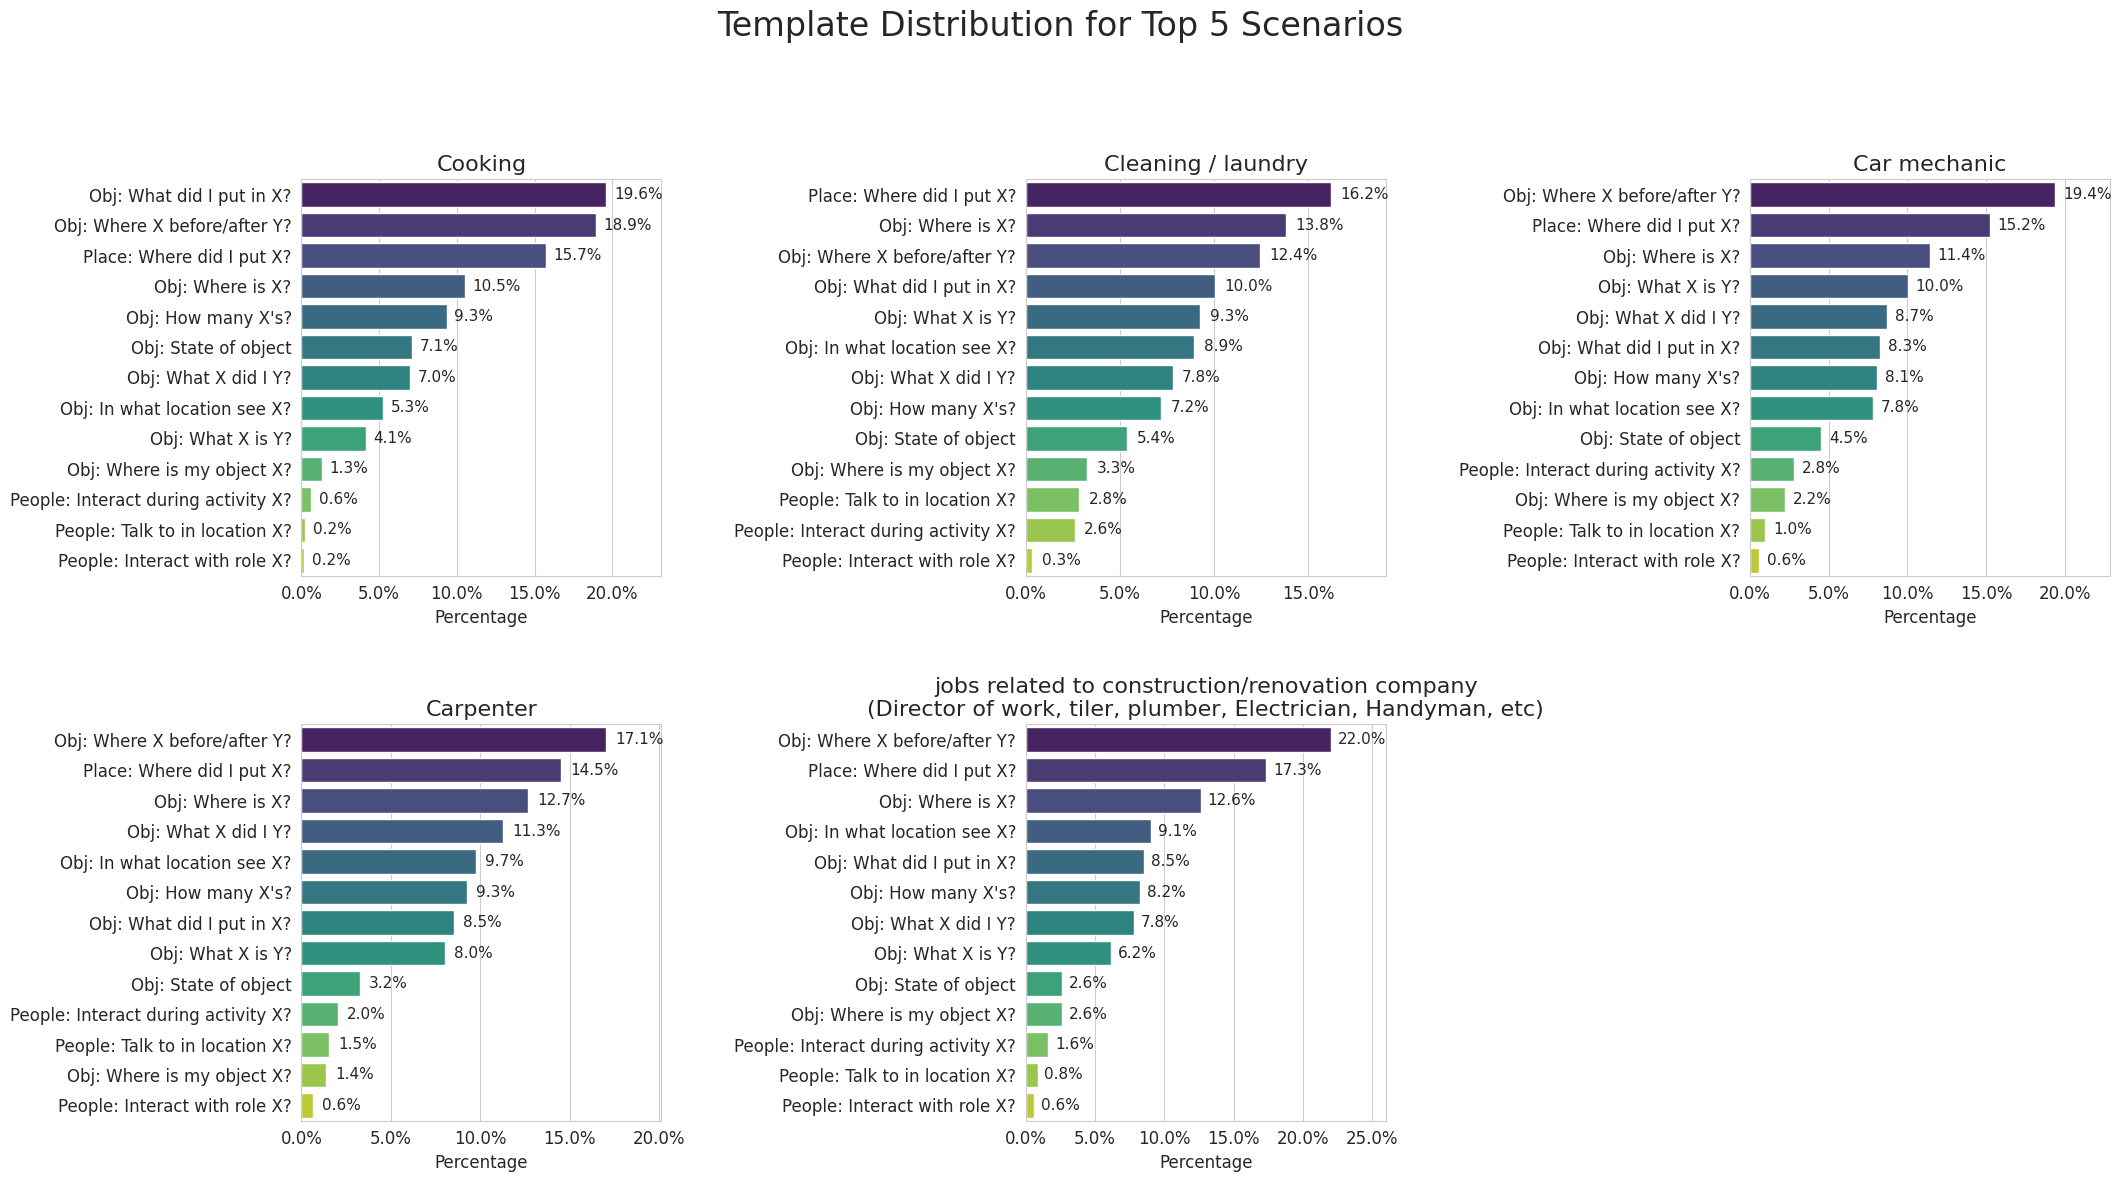

In [ ]:
# --- FINAL Version: Grid of Ordered Bar Charts with Annotations ---

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

print("--- Generating a Grid of Ordered Bar Charts for Top 5 Scenarios ---")

# --- 1. Data Preparation (Loading and Mapping) ---
try:
    # Load ego4d.json
    ego4d_path = '/content/colab_local_storage/ego4d_data/ego4d.json'
    with open(ego4d_path, 'r') as f:
        ego4d_data = json.load(f)

    # Create a dictionary to map video_uid -> scenario
    video_to_scenario = {}
    for video_info in ego4d_data.get("videos", []):
        if "scenarios" in video_info and video_info["scenarios"]:
            video_to_scenario[video_info["video_uid"]] = video_info["scenarios"][0]

    # Add the 'scenario' column to our main DataFrame
    full_df['scenario'] = full_df['video_uid'].map(video_to_scenario)
    full_df_scenario = full_df.dropna(subset=['scenario'])

    # --- 2. Abbreviate Template & Scenario Labels ---
    # Abbreviate long query templates
    template_map = {
        'Objects: Where is object X before / after event Y?': 'Obj: Where X before/after Y?',
        'Place: Where did I put X?': 'Place: Where did I put X?',
        'Objects: Where is object X?': 'Obj: Where is X?',
        'Objects: What did I put in X?': 'Obj: What did I put in X?',
        "Objects: How many X’s? (quantity question)": "Obj: How many X's?",
        'Objects: In what location did I see object X ?': 'Obj: In what location see X?',
        'Objects: What X did I Y?': 'Obj: What X did I Y?',
        'Objects: What X is Y?': 'Obj: What X is Y?',
        'Objects: State of an object': 'Obj: State of object',
        'People: Who did I interact with when I did activity X?': 'People: Interact during activity X?',
        'Objects: Where is my object X?': 'Obj: Where is my object X?',
        'People: Who did I talk to in location X?': 'People: Talk to in location X?',
        'People: When did I talk to or interact with person with role X?': 'People: Interact with role X?'
    }
    full_df_scenario['short_template'] = full_df_scenario['template'].map(template_map)

    # NEW: Abbreviate long scenario names
    scenario_rename_map = {
        'jobs related to construction/renovation company (Director of work, tiler, plumber, Electrician, Handyman, etc)': 'Construction/Renovation Jobs'
    }
    full_df_scenario['scenario'] = full_df_scenario['scenario'].replace(scenario_rename_map)

    # --- 3. Prepare Data for Plotting ---
    contingency_table = pd.crosstab(full_df_scenario['scenario'], full_df_scenario['short_template'])

    # Identify the Top 5 most frequent scenarios
    top_scenarios = contingency_table.sum(axis=1).nlargest(5).index
    filtered_table = contingency_table.loc[top_scenarios]

    # Normalize the data
    normalized_table = filtered_table.div(filtered_table.sum(axis=1), axis=0)

    # --- 4. Create the Grid of Plots Manually for Full Control ---
    print("\n--- Generating Plots ---")

    # Setup the plot grid. For 5 plots, a 2x3 grid is suitable.
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 12))
    # Flatten the axes array to easily iterate over it
    axes = axes.flatten()

    # Iterate through each of the top 5 scenarios and its corresponding subplot axis
    for i, scenario_name in enumerate(top_scenarios):
        ax = axes[i]

        # Get the data for the current scenario, filter out 0% templates, and sort it
        scenario_data = normalized_table.loc[scenario_name]
        scenario_data = scenario_data[scenario_data > 0].sort_values(ascending=False)

        # Create the horizontal bar plot on the specific axis
        sns.barplot(
            x=scenario_data.values,
            y=scenario_data.index,
            ax=ax,
            palette='viridis'
        )

        # Add the percentage labels next to each bar
        for p in ax.patches:
            width = p.get_width()
            ax.text(
                width + 0.005,  # x position (a small offset from the bar end)
                p.get_y() + p.get_height() / 2, # y position (vertically centered)
                f'{width:.1%}', # The text, formatted as a percentage
                va='center',
                fontsize=11
            )

        # Customize each subplot
        ax.set_title(scenario_name, fontsize=16)
        ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))
        ax.set_xlim(0, max(scenario_data.values) * 1.18) # Adjust x-limit to fit labels
        ax.set_xlabel('Percentage', fontsize=12)
        ax.set_ylabel('') # Remove y-label as it's clear from the context

    # Hide any unused subplots in the grid (e.g., the 6th plot in a 2x3 grid)
    for i in range(len(top_scenarios), len(axes)):
        axes[i].set_visible(False)

    # Add a main title for the entire figure
    fig.suptitle('Template Distribution for Top 5 Scenarios', fontsize=24, y=1.01)

    # Adjust layout to prevent titles/labels from overlapping
    fig.tight_layout(pad=3.0)
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}. Please ensure file paths are correct and 'full_df' is loaded.")

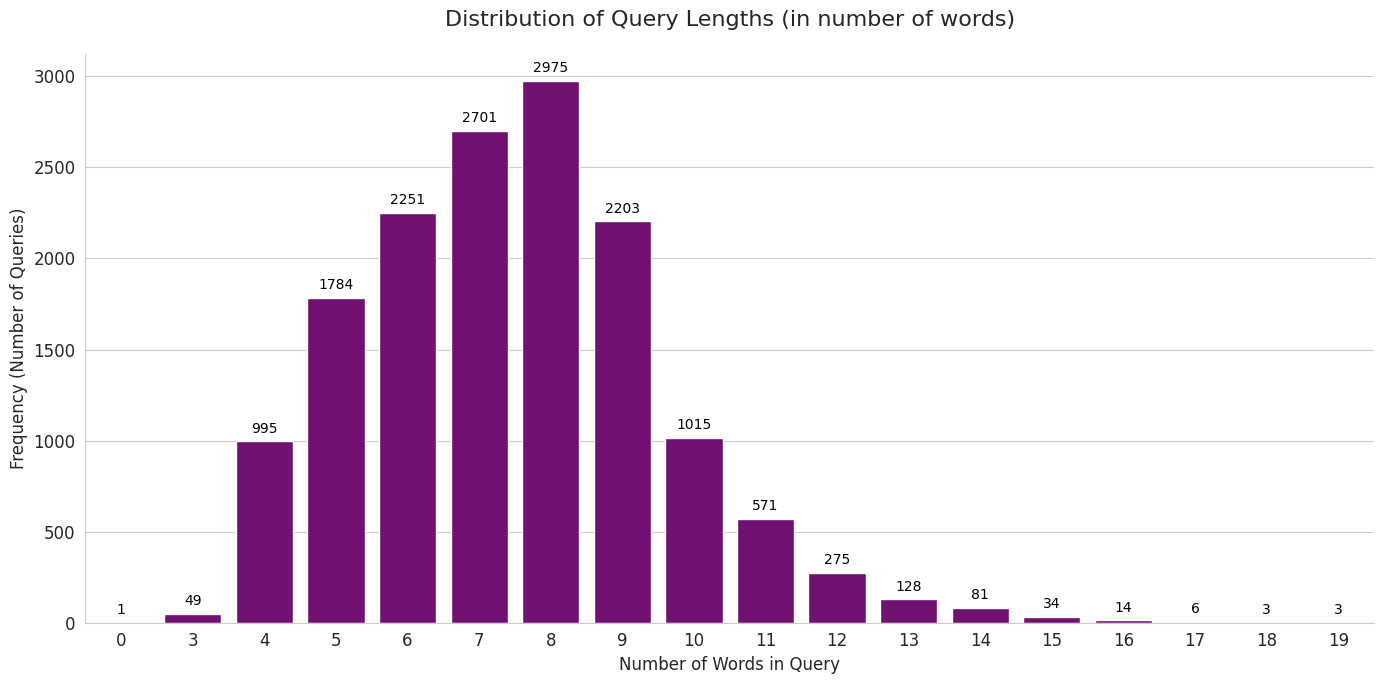

In [ ]:
# --- Cella per il Grafico 1: Distribuzione della Lunghezza delle Query (Migliorato con Bar Plot) ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assumiamo che il DataFrame 'full_df' sia già disponibile
# Calcola la lunghezza di ogni query, se non già presente
if 'query_length' not in full_df.columns:
    full_df['query_length'] = full_df['query'].apply(lambda x: len(x.split()))

# --- NUOVA LOGICA: Usiamo un Bar Plot invece di un Istogramma ---
# 1. Calcola la frequenza di ogni lunghezza di query
length_counts = full_df['query_length'].value_counts().sort_index()

# 2. Crea il grafico a barre
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x=length_counts.index,
    y=length_counts.values,
    color='purple'
)

# 3. Aggiungi le etichette numeriche sopra ogni barra
# Questo codice è identico a quello che abbiamo usato per migliorare l'altro istogramma
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}', # Il testo da mostrare
                    (p.get_x() + p.get_width() / 2., p.get_height()), # La posizione (x, y)
                    ha='center',
                    va='center',
                    xytext=(0, 9), # Offset verticale
                    textcoords='offset points',
                    fontsize=10,
                    color='black')

# 4. Personalizza il grafico per il report
ax.set_title('Distribution of Query Lengths (in number of words)', fontsize=16, pad=20)
ax.set_xlabel('Number of Words in Query', fontsize=12)
ax.set_ylabel('Frequency (Number of Queries)', fontsize=12)

# Rimuovi eventuali bordi non necessari per un look più pulito
sns.despine()
plt.tight_layout()
plt.show()

Delete cache in the drive

In [ ]:
# Questo comando trova e cancella tutte le cartelle __pycache__ nel progetto
!find . -type d -name "__pycache__" -exec rm -r {} +
print("Cache di Python (__pycache__) pulita con successo.")

Cache di Python (__pycache__) pulita con successo.


Create symbolic link for glove file

In [ ]:
%%bash
source vars.sh
CWD=$(pwd)

#GloVe file path
ACTUAL_GLOVE_TXT_FILE_PATH="/content/colab_local_storage/ego4d_data/v1/glove_encoder/glove.840B.300d.txt"

#Path where data_gen.py expect to find the GloVe file
EXPECTED_GLOVE_LINK_PARENT_DIR="$CWD/data/features"
EXPECTED_GLOVE_LINK_FULL_PATH="$EXPECTED_GLOVE_LINK_PARENT_DIR/glove.840B.300d.txt"



# Create parent directory if doesn't exist
mkdir -p "$EXPECTED_GLOVE_LINK_PARENT_DIR"
echo "[GLOVE] Verifica directory genitore del link:"
ls -ld "$EXPECTED_GLOVE_LINK_PARENT_DIR"


# Remove eventually a link with the same name
rm -f "$EXPECTED_GLOVE_LINK_FULL_PATH"
# Create new symbolic link
ln -sfn "$ACTUAL_GLOVE_TXT_FILE_PATH" "$EXPECTED_GLOVE_LINK_FULL_PATH"



Annotations link: /content/drive/MyDrive/EgoVisionProject/Code/episodic_memory/NLQ/VSLNet/data/dataset/nlq_official_v1_glove_vsl_net_egovlp_fp16_run1 -> /content/colab_local_storage/dataset/nlq_official_v1_glove_vsl_net_egovlp_fp16_run1
Features link: /content/drive/MyDrive/EgoVisionProject/Code/episodic_memory/NLQ/VSLNet/data/features/nlq_official_v1_glove_vsl_net_egovlp_fp16_run1/official -> /content/colab_local_storage/features/nlq_official_v1_glove_vsl_net_egovlp_fp16_run1/official
---
[GLOVE] Setup Link Simbolico per GloVe
[GLOVE] Percorso reale del file GloVe: /content/colab_local_storage/ego4d_data/v1/glove_encoder/glove.840B.300d.txt
[GLOVE] Percorso atteso dal link per lo script: /content/drive/MyDrive/EgoVisionProject/Code/episodic_memory/NLQ/VSLNet/data/features/glove.840B.300d.txt
[GLOVE] Verifica directory genitore del link:
drwx------ 6 root root 4096 May 21 12:14 /content/drive/MyDrive/EgoVisionProject/Code/episodic_memory/NLQ/VSLNet/data/features
[GLOVE] OK: Il file sor

Set up LLM and prompt

In [ ]:
# --- CELL 7 (DEFINITIVE VERSION): LLM Setup and Advanced Query Generation ---

# Imports
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import re
import random

# --- Part 1: Load the LLM and Tokenizer ---
# This part is taken from your original notebook to ensure consistency.

# Pick the open source LLM model
LLM_MODEL_ID = "google/gemma-2b-it"

llm_tokenizer = None
llm_model = None

# Configure 4-bit quantization to save memory
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

try:
    print(f"Loading tokenizer for {LLM_MODEL_ID}...")
    llm_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_ID)

    print(f"Loading model {LLM_MODEL_ID} with 4-bit quantization...")
    llm_model = AutoModelForCausalLM.from_pretrained(
        LLM_MODEL_ID,
        device_map="auto",
        quantization_config=quantization_config,
        torch_dtype=torch.bfloat16
    )
    print(f"LLM ({LLM_MODEL_ID}) loaded successfully.")

except Exception as e:
    print(f"ERROR loading LLM: {e}")


# --- Part 2: The Definitive, Advanced Query Generation Function ---
# This function implements our final strategy:
# 1. Filters out unreliable tags (#unsure, #summary).
# 2. Conditionally handles #C (first-person) and #O (third-person) narrations.
# 3. Uses a master prompt with explicit rules to guide the LLM.

def generate_single_query_for_narration(narration_text, model, tokenizer, max_query_length=50):

    if not model or not tokenizer:
        return None

    # 1. Filter out unreliable or non-action tags
    if any(tag in narration_text for tag in ['#unsure', '#summary']):
        return None # Skip this narration

    # 2. Conditionally set up the prompt based on the actor (#C or #O)
    is_other_person = '#O' in narration_text

    if is_other_person:
        # Clean the text for a third-person action
        narration_text_clean = re.sub(r'#O\s?', 'A person ', narration_text).strip()
        # Use third-person oriented question styles
        question_styles = [
            "Ask about the location of an object before or after the action (e.g., 'Where was the cup?').",
            "Ask what the person did with the main object (e.g., 'What did the person do with the cup?').",
            "Ask for the general location of the main object (e.g., 'Where is the cup?').",
            "Ask what the person placed inside or on top of something.",
            "Ask about the quantity of an object (e.g., 'How many cups?')."
        ]
        actor = "the person"
    else: # Default to Camera Wearer (#C)
        # Clean the text for a first-person action
        narration_text_clean = re.sub(r'#C\s?C?', 'I', narration_text).strip()
        # Use first-person oriented question styles
        question_styles = [
            "Ask about the location of an object before or after the action (starts with 'Where was').",
            "Ask what was done with the main object (starts with 'What did I').",
            "Ask for the general location of the main object (starts with 'Where is').",
            "Ask what was placed inside or on top of something.",
            "Ask about the quantity of an object (starts with 'How many')."
        ]
        actor = "I"

    # 3. Create the Master Prompt with all instructions
    master_prompt = f"""You are an assistant creating questions for a video understanding system.
Your task is to analyze an action and generate ONE relevant question about it.

IMPORTANT RULE: The question's topic MUST be strictly limited to the objects and actions mentioned in the action description. Do not introduce outside concepts or topics.

Follow these steps:
1. Read the action description: "{narration_text_clean}"
2. Note that the action was performed by: {actor}. The question should reflect this.
3. Review this list of possible question styles:
- {question_styles[0]}
- {question_styles[1]}
- {question_styles[2]}
- {question_styles[3]}
- {question_styles[4]}
4. Choose the SINGLE most logical and appropriate style for the given action.
5. Generate a natural, human-like question in English based on your chosen style.

Generated Question:"""

    # 4. Generate the Query
    input_ids = tokenizer(master_prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **input_ids,
        max_new_tokens=max_query_length,
        num_return_sequences=1,
        do_sample=True,
        temperature=0.7,
        repetition_penalty=1.1,
        pad_token_id=tokenizer.eos_token_id
    )

    response_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # 5. Parse and return the final query
    try:
        query = response_text.split("Generated Question:")[-1].strip()
        if query and "?" in query:
            final_query = query.split('\n')[0].strip()
            # Final check to ensure the LLM didn't just repeat the action
            if final_query.lower() != narration_text_clean.lower():
                return final_query
    except IndexError:
        return None

    return None



Loading tokenizer for google/gemma-2b-it...


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loading model google/gemma-2b-it with 4-bit quantization...


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

None of the available devices `available_devices = None` are supported by the bitsandbytes version you have installed: `bnb_supported_devices = {'"cpu" (needs an Intel CPU and intel_extension_for_pytorch installed and compatible with the PyTorch version)', 'cuda', 'hpu', 'npu', 'xpu', 'mps'}`. Please check the docs to see if the backend you intend to use is available and how to install it: https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend


ERROR loading LLM: None of the available devices `available_devices = None` are supported by the bitsandbytes version you have installed: `bnb_supported_devices = {'"cpu" (needs an Intel CPU and intel_extension_for_pytorch installed and compatible with the PyTorch version)', 'cuda', 'hpu', 'npu', 'xpu', 'mps'}`. Please check the docs to see if the backend you intend to use is available and how to install it: https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend


In [ ]:
# --- DEBUGGING FUNCTION - Sostituisci la tua funzione nella Cella 7 con questa ---
# --- CELL 7 (DEFINITIVE VERSION): LLM Setup and Advanced Query Generation ---

# Imports
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import re
import random

# --- Part 1: Load the LLM and Tokenizer ---
# This part is taken from your original notebook to ensure consistency.

# Pick the open source LLM model
LLM_MODEL_ID = "google/gemma-2b-it"

llm_tokenizer = None
llm_model = None

# Configure 4-bit quantization to save memory
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

try:
    print(f"Loading tokenizer for {LLM_MODEL_ID}...")
    llm_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_ID)

    print(f"Loading model {LLM_MODEL_ID} with 4-bit quantization...")
    llm_model = AutoModelForCausalLM.from_pretrained(
        LLM_MODEL_ID,
        device_map="auto",
        quantization_config=quantization_config,
        torch_dtype=torch.bfloat16
    )
    print(f"LLM ({LLM_MODEL_ID}) loaded successfully.")

except Exception as e:
    print(f"ERROR loading LLM: {e}")

def debug_query_generation(narration_text, model, tokenizer, max_query_length=50):
    """
    A debugging version of the generation function that prints every step.
    """
    print(f"\n--- [DEBUG] Processing narration: '{narration_text.strip()}'")

    # 1. Check for filtered tags
    if any(tag in narration_text for tag in ['#unsure', '#summary']):
        print("  - [DEBUG] RESULT: SKIPPED due to unreliable tag (#unsure or #summary).")
        return None

    # 2. Determine actor and clean text
    is_other_person = '#O' in narration_text
    if is_other_person:
        narration_text_clean = re.sub(r'#O\s?', 'A person ', narration_text).strip()
        actor = "the person"
    else: # Assume #C
        narration_text_clean = re.sub(r'#C\s?C?', 'I', narration_text).strip()
        actor = "I"
    print(f"  - [DEBUG] Actor identified as: '{actor}'. Cleaned text: '{narration_text_clean}'")

    # (The rest of the logic for creating the prompt is the same)
    question_styles = [ "Ask about the location...", "Ask what was done...", "Ask for the general location...", "Ask what was placed...", "Ask about the quantity..."]
    master_prompt = f"""You are an assistant creating questions for a video understanding system.
Your task is to analyze an action and generate ONE relevant question about it.
IMPORTANT RULE: The question's topic MUST be strictly limited to the objects and actions mentioned in the action description. Do not introduce outside concepts or topics.
Follow these steps:
1. Read the action description: "{narration_text_clean}"
2. Note that the action was performed by: {actor}. The question should reflect this.
3. Review this list of possible question styles:
- {question_styles[0]}
- {question_styles[1]}
- {question_styles[2]}
- {question_styles[3]}
- {question_styles[4]}
4. Choose the SINGLE most logical and appropriate style for the given action.
5. Generate a natural, human-like question in English based on your chosen style.

Generated Question:"""
    print("  - [DEBUG] Sending the following prompt to LLM...")
    # print(master_prompt) # Uncomment this line if you want to see the full prompt text

    # 3. Generate the query
    input_ids = tokenizer(master_prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**input_ids, max_new_tokens=max_query_length, pad_token_id=tokenizer.eos_token_id)
    response_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"  - [DEBUG] RAW a-bout from LLM: '{response_text}'")

    # 4. Parse the a-bout
    try:
        query = response_text.split("Generated Question:")[-1].strip()
        print(f"  - [DEBUG] Text after split: '{query}'")
        if query and "?" in query:
            final_query = query.split('\n')[0].strip()
            print(f"  - [DEBUG] RESULT: SUCCESS. Generated query: '{final_query}'")
            return final_query
        else:
            print("  - [DEBUG] RESULT: FAILED. Parsed text is empty or not a question.")
            return None
    except IndexError:
        print("  - [DEBUG] RESULT: FAILED. 'Generated Question:' delimiter not found in LLM a-bout.")
        return None

Loading tokenizer for google/gemma-2b-it...


None of the available devices `available_devices = None` are supported by the bitsandbytes version you have installed: `bnb_supported_devices = {'"cpu" (needs an Intel CPU and intel_extension_for_pytorch installed and compatible with the PyTorch version)', 'cuda', 'hpu', 'npu', 'xpu', 'mps'}`. Please check the docs to see if the backend you intend to use is available and how to install it: https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend


Loading model google/gemma-2b-it with 4-bit quantization...
ERROR loading LLM: None of the available devices `available_devices = None` are supported by the bitsandbytes version you have installed: `bnb_supported_devices = {'"cpu" (needs an Intel CPU and intel_extension_for_pytorch installed and compatible with the PyTorch version)', 'cuda', 'hpu', 'npu', 'xpu', 'mps'}`. Please check the docs to see if the backend you intend to use is available and how to install it: https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend


Create augumented dataset for pretraining:version with semantic grouping (all narrations of the same group goes on the same annotation in the natural language queries array)

In [ ]:
# --- FINAL DEFINITIVE SCRIPT: Robust Sampling Strategy ---
# This version iterates through groups until the desired number of valid annotations is generated.
# This guarantees a non-empty output and solves the "unlucky sampling" problem.

import json
import os
import random
import uuid
from tqdm.auto import tqdm
import glob
import numpy as np

print("--- Start Data Augmentation with Robust Sampling Strategy ---")

# --- STEP 1: Initialization and All Pre-Checks ---
local_data_root = "/content/colab_local_storage"
ego4d_json_path = os.path.join(local_data_root, 'ego4d_data', 'ego4d.json')
narration_path = os.path.join(local_data_root, 'ego4d_data', 'v1', 'annotations', 'narration.json')
val_json_path = os.path.join(local_data_root, 'ego4d_data', 'v1', 'annotations', 'nlq_val.json')
test_json_path = os.path.join(local_data_root, 'ego4d_data', 'v1', 'annotations', 'nlq_test_unannotated.json')
output_json_path = os.path.join(local_data_root, 'ego4d_data', 'augmented_nlq_train_final.json')

print("\n1. Loading val/test sets to identify videos to exclude...")
excluded_video_uids = set()
try:
    with open(val_json_path, 'r') as f: val_data = json.load(f)
    with open(test_json_path, 'r') as f: test_data = json.load(f)
    for video in val_data.get('videos', []):
        excluded_video_uids.add(video['video_uid'])
    for video in test_data.get('videos', []):
        excluded_video_uids.add(video['video_uid'])
    print(f"Found {len(excluded_video_uids)} unique videos to exclude.")
except FileNotFoundError:
    print(f"Warning: Could not find val/test JSON files.")
    excluded_video_uids = set()

print("\n2. Checking for existing pre-extracted video features...")
feature_dir_path = os.environ.get('FEATURE_DIR', '/content/colab_local_storage/ego4d_data/v1/egovlp_fp16')
existing_video_ids = {os.path.basename(f).split('.')[0] for f in glob.glob(os.path.join(feature_dir_path, '*.pt'))}
print(f"Found {len(existing_video_ids)} pre-extracted video feature files.")

print("\n3. Loading main metadata files...")
with open(ego4d_json_path, 'r') as f: ego4d_data = json.load(f)
with open(narration_path, 'r') as f: all_narrations_data = json.load(f)

# --- STEP 2: Pre-compute Beta, Alpha, and Create Lookup Maps ---
print("\n4. Pre-computing lookup maps and parameters...")
video_to_beta_map = {}
for video_uid, video_content in all_narrations_data.items():
    if video_uid in excluded_video_uids or video_uid not in existing_video_ids: continue
    narrations_list = video_content.get("narration_pass_1", {}).get("narrations", [])
    if len(narrations_list) < 2: continue
    narrations_list.sort(key=lambda x: x['timestamp_sec'])
    diffs = [narrations_list[i+1]['timestamp_sec'] - narrations_list[i]['timestamp_sec'] for i in range(len(narrations_list)-1)]
    positive_diffs = [d for d in diffs if d > 0]
    if positive_diffs: video_to_beta_map[video_uid] = np.mean(positive_diffs)

alpha = 4.9
print(f"Using fixed Alpha value from EgoVLP paper: {alpha:.2f}")

video_to_clips_map = {}
for clip in ego4d_data.get('clips', []):
    vid_uid = clip.get('video_uid')
    if vid_uid not in video_to_clips_map: video_to_clips_map[vid_uid] = []
    video_to_clips_map[vid_uid].append(clip)

# --- STEP 3: Create Narration Groups ---
print("\n5. Creating all possible valid narration groups...")
k_narrations = 5
min_duration_sec = 1.0
all_valid_groups = []
all_clips_map = {clip['clip_uid']: clip for clip in ego4d_data.get('clips', [])}
for video_uid, video_content in tqdm(all_narrations_data.items(), desc="Creating Groups"):
    if video_uid not in video_to_beta_map: continue
    clips_for_this_video = video_to_clips_map.get(video_uid, [])
    if not clips_for_this_video: continue
    narrations_list = video_content.get("narration_pass_1", {}).get("narrations", [])
    if len(narrations_list) < k_narrations: continue
    for i in range(len(narrations_list) - k_narrations + 1):
        current_group = narrations_list[i : i + k_narrations]
        group_start_time = current_group[0]['timestamp_sec']
        group_end_time = current_group[-1]['timestamp_sec']
        if group_end_time - group_start_time < min_duration_sec: continue
        parent_clip = next((c for c in clips_for_this_video if c['video_start_sec'] <= group_start_time and c['video_end_sec'] >= group_end_time), None)
        if parent_clip:
            all_valid_groups.append({"video_uid": video_uid, "narrations": current_group, "parent_clip_uid": parent_clip['clip_uid']})
print(f"Found {len(all_valid_groups)} total valid groups.")

# --- STEP 4: Generate until Target is Reached (Robust Sampling) ---
num_groups_to_generate = 50  # Set this to the final number of annotation blocks you want
# num_groups_to_generate = 50  # Use a small number like 50 for a quick but reliable test
print(f"\n6. Generating queries. Goal: {num_groups_to_generate} successful annotation blocks.")

generated_data_groups = []
random.shuffle(all_valid_groups) # Shuffle to process groups in random order

# This progress bar will now accurately reflect the progress towards our goal
with tqdm(total=num_groups_to_generate, desc="Generating Annotations") as pbar:
    for group_data in all_valid_groups:
        if len(generated_data_groups) >= num_groups_to_generate:
            break # Stop when we have collected enough successfully generated groups

        if 'debug_query_generation' not in locals() or 'llm_model' not in locals():
            print("LLM not loaded. Stopping.")
            break

        video_uid = group_data['video_uid']
        beta_i = video_to_beta_map.get(video_uid)
        parent_clip_info = all_clips_map.get(group_data['parent_clip_uid'])
        if not parent_clip_info or not beta_i: continue

        queries_for_this_group = []
        for narration_obj in group_data["narrations"]:
            t_i = narration_obj['timestamp_sec']
            window_duration = beta_i / alpha
            start_time_abs = max(parent_clip_info['video_start_sec'], t_i - (window_duration / 2))
            end_time_abs = min(parent_clip_info['video_end_sec'], t_i + (window_duration / 2))

            if start_time_abs >= end_time_abs: continue

            query_text = debug_query_generation(narration_obj['narration_text'], llm_model, llm_tokenizer)
            if query_text:
                queries_for_this_group.append({
                    "query": query_text, "template": "LLM-Generated-Hybrid",
                    "video_start_sec": start_time_abs, "video_end_sec": end_time_abs,
                    "clip_start_sec": start_time_abs - parent_clip_info['video_start_sec'],
                    "clip_end_sec": end_time_abs - parent_clip_info['video_start_sec']
                })

        # If we successfully generated at least one query for this group, add it and update the progress bar
        if queries_for_this_group:
            generated_data_groups.append({
                "video_uid": video_uid,
                "parent_clip_uid": parent_clip_info['clip_uid'],
                "language_queries": queries_for_this_group
            })
            pbar.update(1)

# --- STEP 5: Create and Save Final JSON File ---
print(f"\n7. Converting {len(generated_data_groups)} annotation blocks to final format...")
final_output = {"version": "1.0", "description": "Augmented NLQ dataset - Hybrid Strategy", "videos": []}
output_videos_map = {}
for datum in tqdm(generated_data_groups, desc="Final Conversion"):
    video_uid = datum['video_uid']
    parent_clip_uid = datum['parent_clip_uid']
    parent_clip_info = all_clips_map.get(parent_clip_uid)
    if not parent_clip_info: continue
    if video_uid not in output_videos_map: output_videos_map[video_uid] = {"video_uid": video_uid, "clips": []}
    video_entry = output_videos_map[video_uid]
    output_clip_entry = next((c for c in video_entry["clips"] if c["clip_uid"] == parent_clip_uid), None)
    if not output_clip_entry:
        output_clip_entry = {"clip_uid": parent_clip_uid, "video_start_sec": parent_clip_info['video_start_sec'], "video_end_sec": parent_clip_info['video_end_sec'], "annotations": []}
        video_entry["clips"].append(output_clip_entry)
    new_annotation_block = {"annotation_uid": str(uuid.uuid4()), "language_queries": datum['language_queries']}
    output_clip_entry["annotations"].append(new_annotation_block)

final_output['videos'] = list(output_videos_map.values())
with open(output_json_path, 'w') as f:
    json.dump(final_output, f, indent=2)

print(f"\nProcess complete! Final augmented dataset saved to: {output_json_path}")

--- Start Data Augmentation with Robust Sampling Strategy ---

1. Loading val/test sets to identify videos to exclude...
Found 505 unique videos to exclude.

2. Checking for existing pre-extracted video features...
Found 9611 pre-extracted video feature files.

3. Loading main metadata files...

4. Pre-computing lookup maps and parameters...
Using fixed Alpha value from EgoVLP paper: 4.90

5. Creating all possible valid narration groups...


Creating Groups:   0%|          | 0/9645 [00:00<?, ?it/s]

Found 590522 total valid groups.

6. Generating queries. Goal: 50 successful annotation blocks.


Generating Annotations:   0%|          | 0/50 [00:00<?, ?it/s]


7. Converting 0 annotation blocks to final format...


Final Conversion: 0it [00:00, ?it/s]


Process complete! Final augmented dataset saved to: /content/colab_local_storage/ego4d_data/augmented_nlq_train_final.json


Save queries on drive


In [ ]:
%%bash

source vars.sh

DEST_PATH="/content/drive/MyDrive/EgoVisionProject/Data"

# Copy the file
cp $LOCAL_DATA_ROOT/ego4d_data/augmented_nlq_train.json "$DEST_PATH"


Dataset preparation using prepare_ego4ddataset.py script. For the aguguemntation pre-training use instead of local train split --> $LOCAL_DATA_ROOT/augmented_nlq_train.json

In [ ]:
%%bash

source vars.sh

# Ensure that output directories for prepare_ego4d_dataset.py exist
mkdir -p "$BASE_DIR"
mkdir -p "$FEATURE_BASE_DIR"

python utils/prepare_ego4d_dataset.py \
    --input_train_split "$LOCAL_DATA_ROOT/ego4d_data/augmented_nlq_train.json" \
    --input_val_split "$LOCAL_VAL_SPLIT" \
    --input_test_split "$LOCAL_TEST_SPLIT" \
    --video_feature_read_path $FEATURE_DIR \
    --clip_feature_save_path $FEATURE_BASE_DIR \
    --output_save_path $BASE_DIR

Reading [train]: /content/colab_local_storage/ego4d_data/v1/annotations/nlq_train.json
# train: 11291
Writing [train]: /content/colab_local_storage/dataset/nlq_official_v1_LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2/train.json
Reading [val]: /content/colab_local_storage/ego4d_data/v1/annotations/nlq_val.json
# val: 3874
Writing [val]: /content/colab_local_storage/dataset/nlq_official_v1_LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2/val.json
Reading [test]: /content/colab_local_storage/ego4d_data/v1/annotations/nlq_test_unannotated.json
# test: 4004
Writing [test]: /content/colab_local_storage/dataset/nlq_official_v1_LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2/test.json


Extracting features: 100%|██████████| 1659/1659 [00:07<00:00, 224.74it/s]


Symbolic links generation: these symbolic links are used to have the annotations and features processed in the right path ( on our working directory and where the files expect to find them)

In [ ]:
%%bash

source vars.sh

CWD=$(pwd)
#Base directory for symbolic link generation
mkdir -p "$CWD/data/dataset"
# Create also the subdirectory $TASK_NAME below features
mkdir -p "$CWD/data/features/$TASK_NAME"

# 1. Annotations link

# Remove the previous link if it exists and create the new one
rm -f "$CWD/data/dataset/$TASK_NAME"
ln -sfn "$BASE_DIR" "$CWD/data/dataset/$TASK_NAME"
echo "Annotations link: $CWD/data/dataset/$TASK_NAME -> $BASE_DIR"

# 2. Processed features link

# Remove the previous link if it exists and create the new one
rm -f "$CWD/data/features/$TASK_NAME/official"
ln -sfn "$FEATURE_BASE_DIR" "$CWD/data/features/$TASK_NAME/official"
echo "Features link: $CWD/data/features/$TASK_NAME/official -> $FEATURE_BASE_DIR"

echo "--- Setup completed. Checks below: ---"
echo "Annotations target ($BASE_DIR) exists?"
ls -ld "$BASE_DIR"
echo "Annotations link ($CWD/data/dataset/$TASK_NAME) points to:"
ls -ld "$CWD/data/dataset/$TASK_NAME"

echo "Features target (FEATURE_BASE_DIR) exists?"
ls -ld "$FEATURE_BASE_DIR"
echo "Features link ($CWD/data/features/$TASK_NAME/official) points to:"
ls -ld "$CWD/data/features/$TASK_NAME/official"

Annotations link: /content/drive/MyDrive/EgoVisionProject/Code/episodic_memory/NLQ/VSLNet/data/dataset/nlq_official_v1_LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2 -> /content/colab_local_storage/dataset/nlq_official_v1_LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2
Features link: /content/drive/MyDrive/EgoVisionProject/Code/episodic_memory/NLQ/VSLNet/data/features/nlq_official_v1_LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2/official -> /content/colab_local_storage/features/nlq_official_v1_LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2/official
--- Setup completed. Checks below: ---
Annotations target (/content/colab_local_storage/dataset/nlq_official_v1_LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2) exists?
drwxr-xr-x 2 root root 4096 Jun  6 01:20 /content/colab_local_storage/dataset/nlq_official_v1_LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2
Annotations link (/content/drive/MyDrive/EgoVisionProject/

Training script, change:

*   --model_type vslbase (to use  vslbase, vslnet is the deafault)
*   --predictor glove (in the modification in which you have to change the encoder)
* --video_feature_dim (256 for ego_vlp features / 1536 for omnivore features)
* use different parameters num epochs=10 (5) and learning rate 0.0025 (0.00025) for train (fine tun data augumented)


In [ ]:
%%bash

source vars.sh

# machine parameters
export DATALOADER_WORKERS=1
export NUM_WORKERS=2
export VAL_JSON_PATH="$LOCAL_VAL_SPLIT"
#use olny for fine tuning
export PRETRAINED_CHECKPOINT_PATH="/content/colab_local_storage/experiments/LLM_Data_Augumentation_pre-train_vsl_net_egovlp_fp16_run2/vslnet_nlq_official_v1_LLM_Data_Augumentation_pre-train_vsl_net_egovlp_fp16_run2_official_128_bert/model/vslnet_1326.t7"

# hyper parameters
export BATCH_SIZE=32
export DIM=128
export NUM_EPOCH=10  #5 for fine tuning
export MAX_POS_LEN=128
export INIT_LR=0.0025 #0.00025 for fine tuning

export TB_LOG_NAME="${NAME}_bs${BATCH_SIZE}_dim${DIM}_epoch${NUM_EPOCH}_ilr${INIT_LR}"

# Create local model & log directory, if doesn't exists
mkdir -p "$LOCAL_MODEL_DIR"

python main.py \
    --task $TASK_NAME \
    --predictor bert \
    --dim $DIM \
    --mode train \
    --video_feature_dim 256 \
    --max_pos_len $MAX_POS_LEN \
    --init_lr $INIT_LR \
    --epochs $NUM_EPOCH \
    --batch_size $BATCH_SIZE \
    --fv official \
    --num_workers $NUM_WORKERS \
    --data_loader_workers $DATALOADER_WORKERS \
    --model_dir $LOCAL_MODEL_DIR/$NAME \
    --eval_gt_json $VAL_JSON_PATH \
    --log_to_tensorboard $TB_LOG_NAME \
    --tb_log_freq 5 \
    --remove_empty_queries_from train #\
    #--resume_from_checkpoint "$PRETRAINED_CHECKPOINT_PATH" only used for data augumentation fine-tuning

Running with Namespace(save_dir='datasets', model_type='vslnet', resume_from_checkpoint='/content/colab_local_storage/experiments/LLM_Data_Augumentation_pre-train_vsl_net_egovlp_fp16_run2/vslnet_nlq_official_v1_LLM_Data_Augumentation_pre-train_vsl_net_egovlp_fp16_run2_official_128_bert/model/vslnet_1326.t7', task='nlq_official_v1_LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2', eval_gt_json='/content/colab_local_storage/ego4d_data/v1/annotations/nlq_val.json', fv='official', max_pos_len=128, num_workers=2, data_loader_workers=1, word_size=None, char_size=None, word_dim=300, video_feature_dim=256, char_dim=50, dim=128, highlight_lambda=5.0, num_heads=8, drop_rate=0.2, predictor='bert', gpu_idx='0', seed=12345, mode='train', epochs=5, batch_size=32, num_train_steps=None, init_lr=0.00025, clip_norm=1.0, warmup_proportion=0.0, extend=0.1, period=100, text_agnostic=False, video_agnostic=False, model_dir='/content/colab_local_storage/experiments/LLM_Data_Augumentation_fine-tunin

2025-06-06 02:56:13.463630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749178573.485750   80992 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749178573.492892   80992 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
evaluate val: 100%|██████████| 122/122 [00:03<00:00, 34.81it/s]

Epoch   5 /   5: 100%|██████████| 323/323 [00:30<00:00, 10.55it/s]


In [ ]:
%%bash

# Carica le variabili per sapere quale cartella cancellare
source vars.sh

echo "--- Cancellazione della cartella dell'esperimento di fine-tuning fallito: $LOCAL_MODEL_DIR/$NAME ---"

# Il comando rm -rf cancella una cartella e tutto il suo contenuto
rm -rf "$LOCAL_MODEL_DIR/$NAME"

echo "--- Cancellazione completata. ---"

--- Cancellazione della cartella dell'esperimento di fine-tuning fallito: /content/colab_local_storage/experiments/LLM_Data_Augumentation_fine-tuning_vsl_net_egovlp_fp16_run2 ---
--- Cancellazione completata. ---


Copy results on google drive to have persistent results

In [ ]:
%%bash
source vars.sh

if [ -d "$LOCAL_MODEL_DIR" ] && [ "$(ls -A $LOCAL_MODEL_DIR)" ]; then
    cp -r -u "$LOCAL_MODEL_DIR"/* "$MODEL_BASE_DIR"
else
    echo "WARNING: Local result directory $LOCAL_MODEL_DIR is empty or doesn't exist"
fi

Process is interrupted.


Test script, change same parameters of train

In [ ]:
%%bash

source vars.sh

export TRAINED_MODEL_DIRECTORY="$MODEL_BASE_DIR/$NAME"
export BATCH_SIZE_TEST=64
# machine parameters
export DATALOADER_WORKERS=1
export NUM_WORKERS=2
export VAL_JSON_PATH="$LOCAL_VAL_SPLIT"

# hyper parameters
export DIM=128
export NUM_EPOCH=10
export MAX_POS_LEN=128
export INIT_LR=0.0025

python main.py \
    --task $TASK_NAME \
    --predictor bert\
    --dim $DIM \
    --video_feature_dim 256 \
    --max_pos_len $MAX_POS_LEN \
    --init_lr $INIT_LR \
    --epochs $NUM_EPOCH \
    --num_workers $NUM_WORKERS \
    --data_loader_workers $DATALOADER_WORKERS \
    --mode test \
    --model_dir $TRAINED_MODEL_DIRECTORY \
    --batch_size $BATCH_SIZE_TEST \
    --fv official \
    --gpu_idx "0"


Starting test for model run: glove_vsl_net_egovlp_fp16_run1
Running with Namespace(save_dir='datasets', model_type='vslnet', task='nlq_official_v1_glove_vsl_net_egovlp_fp16_run1', eval_gt_json=None, fv='official', max_pos_len=128, num_workers=2, data_loader_workers=1, word_size=None, char_size=None, word_dim=300, video_feature_dim=256, char_dim=50, dim=128, highlight_lambda=5.0, num_heads=8, drop_rate=0.2, predictor='bert', gpu_idx='0', seed=12345, mode='test', epochs=10, batch_size=64, num_train_steps=None, init_lr=0.0025, clip_norm=1.0, warmup_proportion=0.0, extend=0.1, period=100, text_agnostic=False, video_agnostic=False, model_dir='/content/drive/MyDrive/EgoVisionProject/Experiments/glove_vsl_net_egovlp_fp16_run1', model_name='vslnet', suffix=None, log_to_tensorboard=None, tb_log_dir='./runs', tb_log_freq=1, slurm=False, slurm_wait=False, slurm_partition='pixar', slurm_constraint='volta', slurm_gpus=1, slurm_cpus=10, slurm_timeout_min=720, slurm_log_folder='slurm_log', remove_emp

2025-05-21 13:40:34.353439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747834834.373870   50995 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747834834.380199   50995 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-21 13:40:34.401075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date